# Model Comparison

This notebook is not yet finished and need to be debugged.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from PIL import Image
import requests
import re
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neighbors import NearestNeighbors

In [46]:
# read and outputs the mtg card db
def db_cards_init():
    columns = ['id','name','text','manaCost','manaValue','colorIdentity','colors','convertedManaCost','type','types','loyalty','power','toughness','keywords',
        'edhrecRank','life','defense','scryfallId','scryfallIllustrationId','scryfallOracleId','relatedCards']
    dtype = {'id': 'int64','name': str,'text': str,'manaCost': str,'manaValue': float,'colorIdentity': str,'colors': str,
            'convertedManaCost': float,'type': str,'types': str,'loyalty': 'object','power': 'object','toughness': 'object',
            'keywords': str,'edhrecRank': 'object','life': 'object','defense': 'object','scryfallId': str,'scryfallIllustrationId': str,
            'scryfallOracleId': str,'relatedCards': str }
    db = pd.read_csv('../data/mtg_cards_data/AllPrintingsCSVFiles/cards.csv',usecols = columns, dtype = dtype)
    return db

# manipulates a db: For each unique value in the given columns, a new column is created with entries 1 if the value is contained that row or 0 else
def vectorize_columns(db, columns):
    index = db.index
    df_list = []
    for col in columns:
        for val in db[col].dropna().str.split(',').explode().unique():
            df_list = df_list  + [ pd.DataFrame({val :[1 if x else 0 for x in db[col].str.contains(val, case=False)]},index = index)]
    db = pd.concat([db]+ df_list,axis=1)
    return db

# A given text is split into labeled subtexts
def effect_type_dist(text):
    txt_ser = pd.Series(text.split('\n'))
    
    act_eff = txt_ser[txt_ser.str.contains(':',regex=False)].to_list()
    txt_ser = txt_ser[~txt_ser.str.contains(':',regex=False)]
    
    tri_eff = txt_ser[txt_ser.str.contains(r'when |whenever |at |[^a-zA-Z]when |[^a-zA-Z]whenever |[^a-zA-Z]at ',case=False)].to_list()
    txt_ser = txt_ser[~txt_ser.str.contains(r'when |whenever |at |[^a-zA-Z]when |[^a-zA-Z]whenever |[^a-zA-Z]at ',case=False)]
    
    kyw_eff = txt_ser[~txt_ser.str.contains('.',regex=False)].to_list()
    
    stt_eff = txt_ser[txt_ser.str.contains('.',regex=False)].to_list()

    return (act_eff,tri_eff,kyw_eff,stt_eff)

def eff_columns(db):
    index = db.index
    db_txt = pd.DataFrame([effect_type_dist(txt) if txt else txt for txt in db.Text],columns=['activated_effects','trigger_effects','keywords_effects','static_effects'],index = index)
    return pd.concat([db,db_txt],axis=1)
    
def tokenizer(txt):
    if(txt):
        return ' '.join(' '.join(' '.join(' '.join(txt.split('.')).split(',')).split('(')).split(')')).split()
    return txt

def db_cards_proc(db):
    db = db.groupby('name',as_index=False).first()
    db['Text'] = db.apply(lambda x: re.sub(r'[\(].*[\)]', '',str(x['text']).replace(x['name'], 'this card').replace(x['name'].split(',')[0], 'this card')) if (x['text']) else x['text'],axis=1)
    db = vectorize_columns(db, ['colorIdentity','keywords','types'])
    db = eff_columns(db)
    db['TokText'] = db['activated_effects'] + db['trigger_effects'] + db['static_effects']
    db['TokText'] = db['TokText'].apply(lambda x: x if isinstance(x, list) else [])
    db['TokText'] = db['TokText'].apply(lambda x: [tokenizer(txt) if txt else txt for txt in x])
    for col in ['loyalty','power','toughness']:
        dic = {db[col].dropna().sort_values().unique()[i]: i for i in range(len(db[col].dropna().sort_values().unique()))}
        db[col] = db[col].map(dic).fillna(0)
    return db

def calc_sim(model,ab_list1,ab_list2):
    assert model != 0,'Model is not initialized'
    ab_list1 = list(filter(bool,ab_list1))
    ab_list2 = list(filter(bool,ab_list2))
    if not (bool(ab_list1) or bool(ab_list2)):
        return 0
    if(type(model) != KeyedVectors):
        mat = np.matrix([[model.wv.n_similarity(ab1,ab2) for ab2 in ab_list2] for ab1 in ab_list1])
    else:
        mat = np.matrix([[model.n_similarity(ab1,ab2) for ab2 in ab_list2] for ab1 in ab_list1])
    smat = sparse.csr_matrix(mat)
    perm = sparse.csgraph.maximum_bipartite_matching(smat, perm_type='row')
    return smat[perm].toarray().trace()

In [55]:
class SCM:
    def __init__(self):
        self.cards = db_cards_proc(db_cards_init())
        self.card_ind = self.cards.index[np.random.randint(0,len(self.cards))]
        self.model = 0
        
    def init_model(self, model_name):
        if(model_name == 'Doc2Vec'):
            documents = [TaggedDocument(doc,[i]) for i,doc in enumerate(self.cards['TokText'].explode().dropna())]
            self.model = Doc2Vec(documents,vector_size=300,window=5,min_count=1,workers=4)
            return True
        if(model_name == 'Word2Vec'):
            sentences = self.cards['TokText'].explode().dropna().to_list()
            self.model = Word2Vec(sentences=sentences,vector_size=300,window=5,min_count=1,workers=4)
            return True
        if(model_name== 'Word2Vec_pretrained'):
            self.model = KeyedVectors.load('word2vec.kv')
            return True
        return False
        
    def get_card(self):
        Im = Image.open(requests.get('https://api.scryfall.com/cards/' + self.cards.loc[self.card_ind,:].scryfallId + '/?format=image&version=small',stream=True).raw)
        display(Im)
        Im.close()
        return self.cards.loc[self.card_ind,:].name
    
    def set_card(self, card_name: str = ''):
        if(bool(card_name)):
            self.card_ind = self.cards.index[self_cards['name'].str.contains(card_name, case=False)][0]
        else: 
            self.card_ind = self.cards.index[np.random.randint(0,len(self.cards))]
        return None
    
    def text_sim(self):
        self.cards['text_sim'] = self.cards['TokText'].apply(lambda txt_list: calc_sim(self.model,txt_list,self.cards.loc[self.card_ind,:].TokText) if txt_list else 0)    
        return None
    
    def get_sim_cards(self, txt_weight:float = 3, base_power_weight:float = 0, base_toughness_weight:float = 0,loyalty_weight:float = 0, keywords_weight:float = 0.5, color_weight:float = 0.5, type_weight:float = 1):
        weight = [txt_weight, base_power_weight,base_toughness_weight, loyalty_weight]
        col = ['text_sim','power','toughness','loyalty']
        dic_weight = {'keywords': keywords_weight,'colorIdentity': color_weight,'types': type_weight}
        for c in ['keywords','colorIdentity','types']:
            new_col = self.cards[c].dropna().str.split(',').explode().unique().tolist()
            col = col + new_col
            weight = weight + [dic_weight[c] for i in range(len(new_col))]
        if not ('text_sim' in self.cards.columns.to_list()):
            print('Please call text_sim() if you are interested in a Card Text dependent search')
            self.cards['text_sim'] = 0        
        db_train = self.cards[col].fillna(0)
        for c, weight in zip(col,weight):
            db_train[c] = db_train[c] * weight
        db_train = db_train.to_numpy()
        ngh = NearestNeighbors(n_neighbors=5)
        ngh.fit(db_train)
        dist, ind = ngh.kneighbors([self.cards.loc[self.card_ind,col].fillna(0).to_numpy()],n_neighbors=5)
        for i in ind[0]: 
            Im = Image.open(requests.get('https://api.scryfall.com/cards/' + self.cards.iloc[i,:].scryfallId + '/?format=image&version=small', stream=True).raw)
            display(Im)
            Im.close()

In [56]:
scm_d2v = SCM()
scm_w2v = SCM()
scm_w2v_pt = SCM()

<ipython-input-46-0517e031e0e4>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db['TokText'] = db['activated_effects'] + db['trigger_effects'] + db['static_effects']
<ipython-input-46-0517e031e0e4>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db['TokText'] = db['activated_effects'] + db['trigger_effects'] + db['static_effects']
<ipython-input-46-0517e031e0e4>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [57]:
scm_d2v.init_model('Doc2Vec')
scm_w2v.init_model('Word2Vec')
scm_w2v_pt.init_model('Word2Vec_pretrained')

True

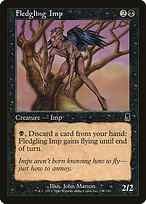

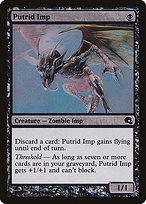

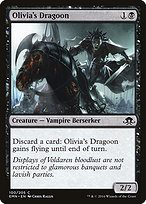

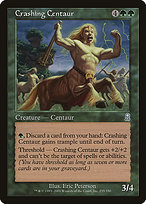

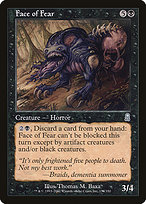

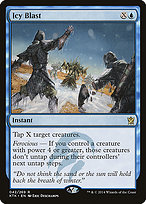

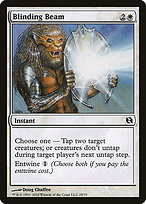

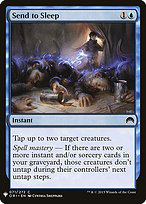

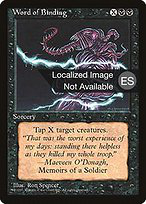

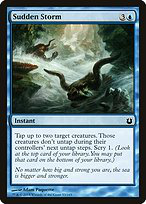

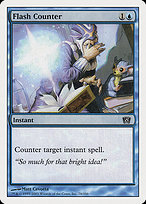

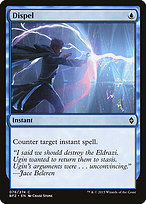

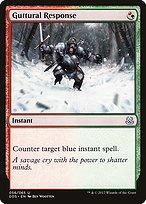

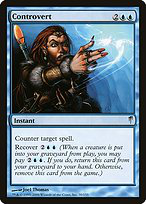

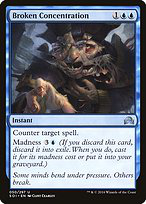

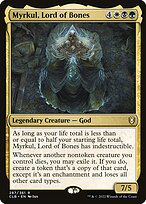

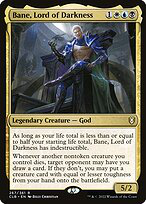

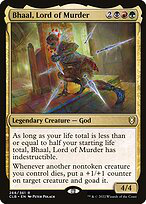

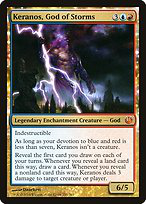

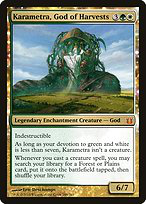

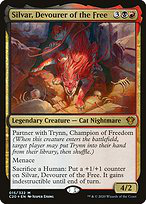

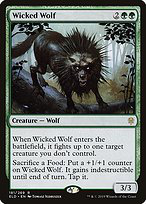

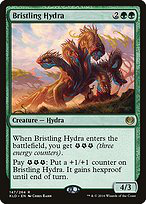

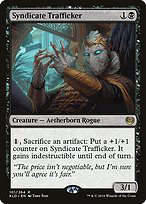

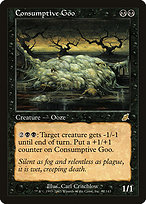

ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [64]:
for i in range(10):
    for model in [scm_d2v,scm_w2v,scm_w2v_pt]:
        model.set_card()
        model.text_sim()
        model.get_sim_cards(1,0,0,0,0,0,0)